In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [2]:
!pip install kagglehub kaggle

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

# hamzamughal1998_brain_tumor_dataset_path = kagglehub.dataset_download('hamzamughal1998/brain_tumor_dataset')

# print('Data source import complete.')
!unzip /content/brain_tumor_dataset.zip


Archive:  /content/brain_tumor_dataset.zip
   creating: brain_tumor_dataset/
   creating: brain_tumor_dataset/no/
  inflating: brain_tumor_dataset/no/N_1.jpg  
  inflating: brain_tumor_dataset/no/N_10.jpg  
  inflating: brain_tumor_dataset/no/N_11.jpg  
  inflating: brain_tumor_dataset/no/N_12.jpg  
  inflating: brain_tumor_dataset/no/N_13.jpg  
  inflating: brain_tumor_dataset/no/N_14.jpg  
  inflating: brain_tumor_dataset/no/N_15.jpg  
  inflating: brain_tumor_dataset/no/N_16.jpg  
  inflating: brain_tumor_dataset/no/N_17.jpg  
  inflating: brain_tumor_dataset/no/N_18.jpg  
  inflating: brain_tumor_dataset/no/N_19.jpg  
  inflating: brain_tumor_dataset/no/N_2.jpg  
  inflating: brain_tumor_dataset/no/N_20.jpg  
  inflating: brain_tumor_dataset/no/N_21.jpg  
  inflating: brain_tumor_dataset/no/N_22.jpg  
  inflating: brain_tumor_dataset/no/N_23.jpg  
  inflating: brain_tumor_dataset/no/N_24.jpg  
  inflating: brain_tumor_dataset/no/N_25.jpg  
  inflating: brain_tumor_dataset/no/N_26.j

In [4]:
!pip install torch torchvision timm tqdm scikit-learn matplotlib opencv-python

In [5]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 40.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_ver

In [2]:
!pip install simpleitk

In [9]:
import os
import numpy as np
import random
import shutil
import time
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from tqdm import tqdm
from copy import deepcopy
import timm
import cv2
import SimpleITK as sitk
from scipy import ndimage
from skimage.segmentation import mark_boundaries
from captum.attr import LayerGradCam
import io
from PIL import Image

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Global settings
OPTIM_PARAMS = {"lr": 1e-5}
OPTIM = torch.optim.AdamW
CRITERIUM = torch.nn.CrossEntropyLoss
BATCH_SIZE = 4
IMAGE_SIZE = 256
N_EPOCHS = 50
PATIENCE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 2 if torch.cuda.is_available() else 4
XAI_METHODS = ['grad-cam']  # Only Grad-CAM as XAI method

# Fix for the "Input type and weight type should be the same" error
# Add this to your code before training

def fix_model_cuda_issue(model, device):
    """
    Ensure all parts of the model are on the correct device.

    Args:
        model: The PyTorch model
        device: Target device ('cuda' or 'cpu')

    Returns:
        Model with all parts on the correct device
    """
    # First move the model to CPU to reset any mixed states
    model = model.to('cpu')

    # Then move the entire model to the target device
    # model = model.to(device)
    model = fix_model_cuda_issue(model, DEVICE)

    # Explicitly move all model parameters to the device
    for param in model.parameters():
        param.data = param.data.to(device)
        if param._grad is not None:
            param._grad.data = param._grad.data.to(device)

    # Return the fixed model
    return model

# Fix for TensorBoard graph visualization
def add_model_graph_safely(writer, model, device='cuda'):
    """
    Safely add model graph to TensorBoard, handling potential errors.

    Args:
        writer: TensorBoard SummaryWriter
        model: PyTorch model
        device: Target device
    """
    try:
        # Create a copy of the model on CPU for graph tracing
        graph_model = deepcopy(model).to('cpu')
        dummy_input = torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE, device='cpu')
        writer.add_graph(graph_model, dummy_input)
        print("Model graph successfully added to TensorBoard")
    except Exception as e:
        print(f"Warning: Could not add model graph to TensorBoard: {e}")
        # Continue without the graph visualization

class EnhancedFuzzyLogic:
    """
    Enhanced fuzzy logic implementation with multiple membership functions and operations.
    """

    def __init__(self):
        """Initialize fuzzy logic system"""
        pass

    def triangular_membership(self, x, a, b, c):
        """
        Triangular membership function.

        Args:
            x: Input values (numpy array or scalar)
            a, b, c: Parameters defining triangular function (a < b < c)

        Returns:
            Membership values
        """
        result = np.zeros_like(x, dtype=float)

        # First segment
        mask1 = (x >= a) & (x < b)
        result[mask1] = (x[mask1] - a) / (b - a)

        # Second segment
        mask2 = (x >= b) & (x <= c)
        result[mask2] = (c - x[mask2]) / (c - b)

        return result

    def trapezoidal_membership(self, x, a, b, c, d):
        """
        Trapezoidal membership function.

        Args:
            x: Input values (numpy array or scalar)
            a, b, c, d: Parameters defining trapezoidal function (a < b < c < d)

        Returns:
            Membership values
        """
        result = np.zeros_like(x, dtype=float)

        # First segment (rising)
        mask1 = (x >= a) & (x < b)
        result[mask1] = (x[mask1] - a) / (b - a)

        # Flat segment (top)
        mask2 = (x >= b) & (x <= c)
        result[mask2] = 1.0

        # Last segment (falling)
        mask3 = (x > c) & (x <= d)
        result[mask3] = (d - x[mask3]) / (d - c)

        return result

    def gaussian_membership(self, x, mean, sigma):
        """
        Gaussian membership function.

        Args:
            x: Input values (numpy array or scalar)
            mean: Center of the Gaussian
            sigma: Standard deviation of the Gaussian

        Returns:
            Membership values
        """
        return np.exp(-0.5 * ((x - mean) / sigma) ** 2)

    def s_function(self, x, a, b, c):
        """
        S-shaped membership function.

        Args:
            x: Input values (numpy array or scalar)
            a, b, c: Parameters defining S-function (a < b < c)

        Returns:
            Membership values
        """
        result = np.zeros_like(x, dtype=float)

        # S-function definition
        mask1 = (x <= a)
        mask2 = (x > a) & (x <= b)
        mask3 = (x > b) & (x <= c)
        mask4 = (x > c)

        result[mask1] = 0
        result[mask2] = 2 * ((x[mask2] - a) / (c - a)) ** 2
        result[mask3] = 1 - 2 * ((x[mask3] - c) / (c - a)) ** 2
        result[mask4] = 1

        return result

    def intensification(self, membership, strength=2.0):
        """
        Intensify fuzzy membership values (contrast enhancement).

        Args:
            membership: Membership values (0-1)
            strength: Intensification strength

        Returns:
            Intensified membership values
        """
        enhanced = np.zeros_like(membership)
        mask1 = (membership <= 0.5)
        mask2 = (membership > 0.5)

        enhanced[mask1] = 2 ** (strength-1) * membership[mask1] ** strength
        enhanced[mask2] = 1 - 2 ** (strength-1) * (1 - membership[mask2]) ** strength

        return enhanced

    def fuzzy_contrast_enhancement(self, image, method='full'):
        """
        Apply fuzzy contrast enhancement to an image.

        Args:
            image: Input image
            method: 'simple', 'adaptive', or 'full'

        Returns:
            Enhanced image
        """
        # Ensure image is grayscale and normalized to [0,1]
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        normalized = gray.astype(float) / 255.0

        if method == 'simple':
            # Simple approach with single S-function and intensification
            mean_val = np.mean(normalized)
            a = max(0, mean_val - 0.3)
            c = min(1, mean_val + 0.3)
            b = (a + c) / 2

            membership = self.s_function(normalized, a, b, c)
            enhanced = self.intensification(membership)

        elif method == 'adaptive':
            # Adaptive approach with different parameters for dark/bright regions
            dark_regions = self.gaussian_membership(normalized, 0.2, 0.1)
            bright_regions = self.gaussian_membership(normalized, 0.8, 0.1)
            mid_regions = 1 - dark_regions - bright_regions
            mid_regions[mid_regions < 0] = 0

            # Different enhancement for each region
            enhanced_dark = self.intensification(normalized * 2) * dark_regions
            enhanced_bright = (1 - self.intensification(1 - normalized)) * bright_regions
            enhanced_mid = self.intensification(normalized) * mid_regions

            # Combine the results
            enhanced = enhanced_dark + enhanced_bright + enhanced_mid

        else:  # 'full' method
            # Full approach with multiple membership functions and rules

            # Define input fuzzy sets (dark, medium, bright)
            dark = self.gaussian_membership(normalized, 0.2, 0.15)
            medium = self.gaussian_membership(normalized, 0.5, 0.15)
            bright = self.gaussian_membership(normalized, 0.8, 0.15)

            # Define enhancement strategies
            enhance_dark = 2 * normalized * dark
            enhance_medium = self.intensification(normalized) * medium
            preserve_bright = normalized * bright

            # Combine results (fuzzy rule aggregation)
            enhanced = enhance_dark + enhance_medium + preserve_bright
            enhanced = enhanced / (dark + medium + bright + 1e-10)  # Normalization

        # Scale back to [0, 255]
        result = np.clip(enhanced * 255, 0, 255).astype(np.uint8)

        return result

    def adaptive_fuzzy_thresholding(self, image):
        """
        Perform adaptive fuzzy thresholding for segmentation.

        Args:
            image: Input image

        Returns:
            Segmented binary image
        """
        # Ensure image is grayscale
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Normalize to [0,1]
        normalized = gray.astype(float) / 255.0

        # Create local windows with different sizes
        window_sizes = [3, 5, 7]
        local_features = []

        for size in window_sizes:
            # Local mean
            local_mean = cv2.blur(normalized, (size, size))
            # Local variance
            local_var = cv2.blur(normalized**2, (size, size)) - local_mean**2
            local_features.append((local_mean, local_var))

        # Create foreground and background memberships
        foreground = np.zeros_like(normalized)
        background = np.zeros_like(normalized)

        for mean, var in local_features:
            # Adaptive thresholds
            threshold = mean - 0.2 * np.sqrt(var)

            # Create fuzzy sets
            fg = self.s_function(normalized, threshold-0.1, threshold, threshold+0.1)
            bg = 1 - fg

            # Combine evidence
            foreground += fg
            background += bg

        # Normalize by number of features
        foreground /= len(local_features)
        background /= len(local_features)

        # Final decision with defuzzification
        result = np.zeros_like(gray)
        result[foreground > background] = 255

        return result.astype(np.uint8)


class MedicalImageEnhancer:
    """
    A class containing advanced image enhancement techniques for medical images.
    """

    def __init__(self, visualization=True):
        """
        Initialize the enhancer.

        Args:
            visualization (bool): Whether to enable visualization capabilities
        """
        self.visualization = visualization
        self.fuzzy_logic = EnhancedFuzzyLogic()

    def hybrid_he_clahe(self, image, clip_limit=2.0, tile_grid_size=(8, 8), he_weight=0.5):
        """
        Apply a hybrid of global histogram equalization and CLAHE.

        Args:
            image: Input image
            clip_limit: Clipping limit for CLAHE
            tile_grid_size: Tile grid size for CLAHE
            he_weight: Weight for histogram equalization (0-1)

        Returns:
            Enhanced image
        """
        # Convert to grayscale if needed
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Apply global histogram equalization
        he_image = cv2.equalizeHist(gray)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        clahe_image = clahe.apply(gray)

        # Combine the two enhanced images with weighted average
        hybrid_image = cv2.addWeighted(he_image, he_weight, clahe_image, 1 - he_weight, 0)

        return hybrid_image

    def fuzzy_enhancement(self, image, method='full', membership_range=(0.3, 0.7)):
        """
        Enhance image using fuzzy logic techniques.

        Args:
            image: Input image
            method: 'simple', 'adaptive', 'full', or 'classic'
            membership_range: Tuple with (low, high) membership thresholds (for 'classic' method)

        Returns:
            Enhanced image
        """
        if method == 'classic':
            # Original fuzzy enhancement implementation
            # Ensure image is grayscale and normalized to [0,1]
            if len(image.shape) > 2 and image.shape[2] > 1:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()

            normalized = gray.astype(float) / 255.0

            # Create membership map (S-function)
            a, c = membership_range
            b = (a + c) / 2
            membership = self.fuzzy_logic.s_function(normalized, a, b, c)

            # Enhance using INT operator (Intensification)
            enhanced = np.zeros_like(normalized)
            mask1 = (membership <= 0.5)
            mask2 = (membership > 0.5)

            enhanced[mask1] = 2 * membership[mask1] ** 2
            enhanced[mask2] = 1 - 2 * (1 - membership[mask2]) ** 2

            # Scale back to [0, 255]
            result = np.clip(enhanced * 255, 0, 255).astype(np.uint8)
            return result
        else:
            # Use enhanced fuzzy contrast methods
            return self.fuzzy_logic.fuzzy_contrast_enhancement(image, method)

    def fuzzy_morphological_enhancement(self, image, kernel_size=5):
        """
        Apply fuzzy morphological operations for enhancement.

        Args:
            image: Input image
            kernel_size: Size of the structuring element

        Returns:
            Enhanced image
        """
        # Ensure image is grayscale
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        normalized = gray.astype(float) / 255.0

        # Create fuzzy structuring element (Gaussian)
        x = np.linspace(-1, 1, kernel_size)
        y = np.linspace(-1, 1, kernel_size)
        X, Y = np.meshgrid(x, y)
        kernel = np.exp(-4 * (X**2 + Y**2))
        kernel /= kernel.sum()  # Normalize

        # Fuzzy dilation
        dilated = cv2.filter2D(normalized, -1, kernel)

        # Fuzzy erosion
        eroded = 1 - cv2.filter2D(1 - normalized, -1, kernel)

        # Fuzzy opening and closing
        opened = cv2.filter2D(eroded, -1, kernel)  # erosion followed by dilation
        closed = 1 - cv2.filter2D(1 - dilated, -1, kernel)  # dilation followed by erosion

        # Combine operations for enhancement
        enhanced = 0.5 * (opened + closed)

        # Scale back to [0, 255]
        result = np.clip(enhanced * 255, 0, 255).astype(np.uint8)

        return result

    def morphological_enhancement(self, image, method='tophat', kernel_size=15):
        """
        Enhance image using morphological operations.

        Args:
            image: Input image
            method: 'tophat', 'bottomhat', 'both', or 'fuzzy'
            kernel_size: Size of the structuring element

        Returns:
            Enhanced image
        """
        # Ensure image is grayscale
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        if method == 'fuzzy':
            return self.fuzzy_morphological_enhancement(gray, kernel_size)

        # Create structuring element
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

        if method == 'tophat':
            # Top-hat transform: Removes dark regions, enhances bright structures
            result = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
            # Add back to original for enhancement
            enhanced = cv2.add(gray, result)

        elif method == 'bottomhat':
            # Bottom-hat transform: Removes bright regions, enhances dark structures
            result = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
            # Subtract from original for enhancement
            enhanced = cv2.subtract(gray, result)

        elif method == 'both':
            # Combine both top-hat and bottom-hat for enhanced contrast
            tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
            bottomhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
            enhanced = cv2.add(gray, tophat)
            enhanced = cv2.subtract(enhanced, bottomhat)

        else:
            raise ValueError("Method must be 'tophat', 'bottomhat', 'both', or 'fuzzy'")

        return enhanced

    def intensity_normalization(self, image, method='zscore', target_mean=None, target_std=None,
                              p_min=1, p_max=99):
        """
        Normalize image intensity.

        Args:
            image: Input image
            method: 'zscore', 'nyul', or 'minmax'
            target_mean: Target mean for Z-score normalization (optional)
            target_std: Target standard deviation for Z-score normalization (optional)
            p_min: Minimum percentile for min-max normalization
            p_max: Maximum percentile for min-max normalization

        Returns:
            Normalized image
        """
        # Ensure image is grayscale
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        gray = gray.astype(float)

        if method == 'zscore':
            # Z-score normalization
            mean = np.mean(gray)
            std = np.std(gray)

            if std == 0:  # Avoid division by zero
                return gray.astype(np.uint8)

            normalized = (gray - mean) / std

            # Optional rescaling to target mean and std
            if target_mean is not None and target_std is not None:
                normalized = normalized * target_std + target_mean

            # Rescale to [0, 255]
            normalized = 255 * (normalized - np.min(normalized)) / (np.max(normalized) - np.min(normalized))

        elif method == 'nyul':
            # Simplified Nyul normalization (histogram matching to standard)
            # Compute landmark intensities at specified percentiles
            p_landmarks = np.linspace(p_min, p_max, 10)
            landmarks = np.percentile(gray, p_landmarks)

            # Create standard scale (can be adjusted based on domain knowledge)
            standard_landmarks = np.linspace(0, 255, len(landmarks))

            # Map each intensity using piecewise linear interpolation
            normalized = np.zeros_like(gray)
            for i in range(len(landmarks) - 1):
                mask = (gray >= landmarks[i]) & (gray <= landmarks[i + 1])
                if np.any(mask):
                    slope = (standard_landmarks[i + 1] - standard_landmarks[i]) / (landmarks[i + 1] - landmarks[i])
                    normalized[mask] = standard_landmarks[i] + slope * (gray[mask] - landmarks[i])

            # Handle edge cases
            normalized[gray < landmarks[0]] = standard_landmarks[0]
            normalized[gray > landmarks[-1]] = standard_landmarks[-1]

        elif method == 'minmax':
            # Min-max normalization using percentiles to handle outliers
            p_low = np.percentile(gray, p_min)
            p_high = np.percentile(gray, p_max)

            normalized = np.clip(gray, p_low, p_high)
            normalized = 255 * (normalized - p_low) / (p_high - p_low)

        else:
            raise ValueError("Method must be 'zscore', 'nyul', or 'minmax'")

        return np.clip(normalized, 0, 255).astype(np.uint8)

    def bias_field_correction(self, image, mask=None, num_iterations=50, num_fitting_levels=4):
        """
        Apply N4ITK bias field correction.

        Args:
            image: Input image
            mask: Binary mask specifying region of interest (optional)
            num_iterations: Number of iterations per fitting level
            num_fitting_levels: Number of fitting levels

        Returns:
            Corrected image
        """
        try:
            # Convert to SimpleITK image
            if len(image.shape) > 2 and image.shape[2] > 1:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()

            # Convert to float and rescale to [0, 1]
            gray_float = gray.astype(float) / 255.0

            sitk_image = sitk.GetImageFromArray(gray_float)

            # Create mask if not provided
            if mask is None:
                # Create a basic mask by thresholding
                mask = np.ones_like(gray, dtype=np.uint8)
                mask[gray < 5] = 0  # Exclude very dark areas

            sitk_mask = sitk.GetImageFromArray(mask)

            # Configure the N4 bias field correction filter
            corrector = sitk.N4BiasFieldCorrectionImageFilter()
            corrector.SetMaximumNumberOfIterations([num_iterations] * num_fitting_levels)

            # Apply correction
            output = corrector.Execute(sitk_image, sitk_mask)

            # Get bias field (for visualization purposes)
            bias_field = sitk.Exp(corrector.GetLogBiasFieldAsImage(sitk_image))

            # Convert back to numpy
            corrected_image = sitk.GetArrayFromImage(output)
            bias_field_np = sitk.GetArrayFromImage(bias_field)

            # Rescale to [0, 255]
            corrected_image = np.clip(corrected_image * 255, 0, 255).astype(np.uint8)

            return corrected_image, bias_field_np

        except Exception as e:
            print(f"Bias field correction failed: {e}")
            return image, np.ones_like(gray, dtype=float)

    def visualize_enhancement(self, original, enhanced, title="Image Enhancement"):
        """
        Visualize original and enhanced images side by side.
        """
        if not self.visualization:
            return

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(original, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(enhanced, cmap='gray')
        plt.title('Enhanced Image')
        plt.axis('off')

        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    def visualize_all_enhancements(self, image):
        """
        Apply and visualize all enhancement methods on a single image.

        Args:
            image: Input image
        """
        if not self.visualization:
            return

        # Convert to grayscale if needed
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Apply all enhancement methods
        he_clahe = self.hybrid_he_clahe(gray)
        fuzzy_classic = self.fuzzy_enhancement(gray, method='classic')
        fuzzy_advanced = self.fuzzy_enhancement(gray, method='full')
        tophat = self.morphological_enhancement(gray, method='tophat')
        fuzzy_morph = self.morphological_enhancement(gray, method='fuzzy')
        both_morph = self.morphological_enhancement(gray, method='both')
        zscore = self.intensity_normalization(gray, method='zscore')
        nyul = self.intensity_normalization(gray, method='nyul')
        n4_corrected, bias_field = self.bias_field_correction(gray)

        # Create visualization
        plt.figure(figsize=(15, 12))

        plt.subplot(3, 3, 1)
        plt.imshow(gray, cmap='gray')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(3, 3, 2)
        plt.imshow(he_clahe, cmap='gray')
        plt.title('Hybrid HE-CLAHE')
        plt.axis('off')

        plt.subplot(3, 3, 3)
        plt.imshow(fuzzy_classic, cmap='gray')
        plt.title('Classic Fuzzy Enhancement')
        plt.axis('off')

        plt.subplot(3, 3, 4)
        plt.imshow(fuzzy_advanced, cmap='gray')
        plt.title('Advanced Fuzzy Enhancement')
        plt.axis('off')

        plt.subplot(3, 3, 5)
        plt.imshow(tophat, cmap='gray')
        plt.title('Top-Hat Transform')
        plt.axis('off')

        plt.subplot(3, 3, 6)
        plt.imshow(fuzzy_morph, cmap='gray')
        plt.title('Fuzzy Morphological')
        plt.axis('off')

        plt.subplot(3, 3, 7)
        plt.imshow(both_morph, cmap='gray')
        plt.title('Combined Morphological')
        plt.axis('off')

        plt.subplot(3, 3, 8)
        plt.imshow(zscore, cmap='gray')
        plt.title('Z-Score Normalization')
        plt.axis('off')

        plt.subplot(3, 3, 9)
        plt.imshow(n4_corrected, cmap='gray')
        plt.title('N4ITK Bias Correction')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


class EnhancedDataAugmentor:
    """
    Class for advanced data augmentation with image enhancement techniques.
    """

    def __init__(self, enhancer=None):
        """
        Initialize the augmentor.

        Args:
            enhancer: MedicalImageEnhancer instance
        """
        self.enhancer = enhancer if enhancer else MedicalImageEnhancer(visualization=False)

    def _random_enhance(self, image):
        """
        Apply a random enhancement technique.

        Args:
            image: Input image

        Returns:
            Enhanced image
        """
        # Choose a random enhancement technique
        technique = random.choice([
            'hybrid_he_clahe',
            'fuzzy_classic',
            'fuzzy_advanced',
            'morphological_tophat',
            'morphological_bottomhat',
            'fuzzy_morphological',
            'morphological_both',
            'zscore_normalization',
            'nyul_normalization',
            'bias_field_correction',
            'none'  # Sometimes apply no enhancement
        ])

        # Ensure image is grayscale
        if len(image.shape) > 2 and image.shape[2] > 1:
            img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            img = image.copy()

        # Apply the chosen enhancement
        if technique == 'hybrid_he_clahe':
            clip_limit = random.uniform(1.0, 5.0)
            tile_size = random.choice([4, 8, 16])
            he_weight = random.uniform(0.2, 0.8)
            enhanced = self.enhancer.hybrid_he_clahe(img, clip_limit=clip_limit,
                                                  tile_grid_size=(tile_size, tile_size),
                                                  he_weight=he_weight)

        elif technique == 'fuzzy_classic':
            low = random.uniform(0.2, 0.4)
            high = random.uniform(0.6, 0.8)
            enhanced = self.enhancer.fuzzy_enhancement(img, method='classic',
                                                     membership_range=(low, high))

        elif technique == 'fuzzy_advanced':
            method = random.choice(['simple', 'adaptive', 'full'])
            enhanced = self.enhancer.fuzzy_enhancement(img, method=method)

        elif technique == 'morphological_tophat':
            kernel_size = random.choice([7, 11, 15, 19])
            enhanced = self.enhancer.morphological_enhancement(img, method='tophat',
                                                             kernel_size=kernel_size)

        elif technique == 'morphological_bottomhat':
            kernel_size = random.choice([7, 11, 15, 19])
            enhanced = self.enhancer.morphological_enhancement(img, method='bottomhat',
                                                             kernel_size=kernel_size)

        elif technique == 'fuzzy_morphological':
            kernel_size = random.choice([3, 5, 7, 9])
            enhanced = self.enhancer.morphological_enhancement(img, method='fuzzy',
                                                             kernel_size=kernel_size)

        elif technique == 'morphological_both':
            kernel_size = random.choice([7, 11, 15, 19])
            enhanced = self.enhancer.morphological_enhancement(img, method='both',
                                                             kernel_size=kernel_size)

        elif technique == 'zscore_normalization':
            target_mean = random.uniform(100, 150)
            target_std = random.uniform(30, 60)
            enhanced = self.enhancer.intensity_normalization(img, method='zscore',
                                                           target_mean=target_mean,
                                                           target_std=target_std)

        elif technique == 'nyul_normalization':
            p_min = random.randint(1, 5)
            p_max = random.randint(95, 99)
            enhanced = self.enhancer.intensity_normalization(img, method='nyul',
                                                           p_min=p_min, p_max=p_max)

        elif technique == 'bias_field_correction':
            enhanced, _ = self.enhancer.bias_field_correction(img,
                                                           num_iterations=random.choice([20, 50]),
                                                           num_fitting_levels=random.choice([2, 4]))
        else:  # 'none'
            enhanced = img

        return enhanced

    def augment_image(self, image, num_augmentations=1, include_original=False):
        """
        Generate augmented versions of an image.

        Args:
            image: Input image
            num_augmentations: Number of augmented images to generate
            include_original: Whether to include the original image

        Returns:
            List of augmented images
        """
        result = []
        if include_original:
            result.append(image.copy())

        for _ in range(num_augmentations):
            # Apply random enhancement
            enhanced = self._random_enhance(image)

            # Apply additional geometric augmentations (optional)
            if random.random() > 0.5:
                enhanced = cv2.flip(enhanced, random.choice([0, 1, -1]))  # flip

            if random.random() > 0.5:
                angle = random.uniform(-10, 10)
                rows, cols = enhanced.shape
                M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
                enhanced = cv2.warpAffine(enhanced, M, (cols, rows))

            # Add to result
            result.append(enhanced)

        return result

    def augment_directory(self, input_dir, output_dir, num_per_image=5):
        """
        Augment all images in a directory.

        Args:
            input_dir: Directory containing original images
            output_dir: Directory to save augmented images
            num_per_image: Number of augmentations per image
        """
        os.makedirs(output_dir, exist_ok=True)

        image_files = [f for f in os.listdir(input_dir)
                     if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]

        for img_file in tqdm(image_files, desc=f"Augmenting images in {input_dir}"):
            # Load image
            img_path = os.path.join(input_dir, img_file)
            image = cv2.imread(img_path)

            if image is None:
                print(f"Warning: Could not load {img_path}")
                continue

            # Generate augmentations
            augmentations = self.augment_image(image, num_per_image)

            # Save augmented images
            base_name = os.path.splitext(img_file)[0]
            for i, aug_img in enumerate(augmentations):
                aug_path = os.path.join(output_dir, f"{base_name}_aug_{i}.png")
                cv2.imwrite(aug_path, aug_img)


class XAIVisualizer:
    """
    Class for explainable AI visualizations, using only Grad-CAM.
    """

    def __init__(self, model, device=DEVICE):
        """
        Initialize the XAI visualizer.

        Args:
            model: Trained PyTorch model
            device: Device to run computations on
        """
        self.model = model
        self.device = device
        self.model.to(self.device)
        self.model.eval()

    def _preprocess_image(self, image, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
        """
        Preprocess an image for the model.

        Args:
            image: Input image (numpy array or PIL Image)
            target_size: Target size for resizing

        Returns:
            Tensor ready for model input
        """
        # Convert image to RGB if needed
        if isinstance(image, np.ndarray):
            if len(image.shape) == 2:
                # Grayscale to RGB
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            elif image.shape[2] == 1:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            elif image.shape[2] == 3 and image.dtype == np.uint8:
                # Convert BGR to RGB if needed
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)

        # Apply transformations
        transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        img_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        return img_tensor.to(self.device)

    def _tensor_to_numpy(self, tensor):
        """Convert tensor to numpy array."""
        return tensor.detach().cpu().numpy()

    def apply_grad_cam(self, image, target_class=None):
        """
        Apply Grad-CAM to visualize important regions of the image.

        Args:
            image: Input image
            target_class: Target class (default is the predicted class)

        Returns:
            Original image, attribution heatmap, and overlaid visualization
        """
        # Preprocess image
        img_tensor = self._preprocess_image(image)

        # For SwinV2, use a more appropriate layer for visualization
        if isinstance(self.model, timm.models.swin_transformer_v2.SwinTransformerV2):
            # Use the last block's norm2 layer in the last stage
            target_layer = self.model.layers[-1].blocks[-1].norm2
        else:
            # For CNNs, find the last convolutional layer
            target_layer = None
            for name, module in self.model.named_modules():
                if isinstance(module, nn.Conv2d):
                    target_layer = module

            if target_layer is None:
                raise ValueError("Could not find appropriate target layer for Grad-CAM")

        # Create GradCAM
        grad_cam = LayerGradCam(self.model, target_layer)

        # Get model prediction if target_class is not provided
        if target_class is None:
            with torch.no_grad():
                output = self.model(img_tensor)
                target_class = output.argmax(dim=1).item()

        # Compute attributions
        attribution = grad_cam.attribute(img_tensor, target=target_class)
        attribution = self._tensor_to_numpy(attribution).squeeze()

        # For transformer networks, handle multi-dimensional attributions
        if len(attribution.shape) > 2:
            # Average across feature channels
            attribution = np.mean(attribution, axis=0)

        # Apply ReLU to focus on positive attributions
        heatmap = np.maximum(attribution, 0)

        # Normalize heatmap
        heatmap = heatmap / np.max(heatmap) if np.max(heatmap) > 0 else heatmap

        # Convert to proper dimensions
        if isinstance(image, Image.Image):
            target_size = (image.width, image.height)
        else:
            target_size = (image.shape[1], image.shape[0])

        # Resize with proper interpolation
        heatmap = cv2.resize(heatmap, target_size, interpolation=cv2.INTER_CUBIC)

        # Apply smoothing to make heatmap more interpretable
        heatmap = cv2.GaussianBlur(heatmap, (9, 9), 0)

        # Convert to RGB colormap
        heatmap_colored = cm.jet(heatmap)[:, :, :3] * 255
        heatmap_colored = heatmap_colored.astype(np.uint8)

        # Convert image to numpy if it's PIL
        if isinstance(image, Image.Image):
            orig_img = np.array(image)
        else:
            orig_img = image.copy()

        # Ensure image is RGB
        if len(orig_img.shape) == 2:
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_GRAY2RGB)
        elif orig_img.shape[2] == 1:
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_GRAY2RGB)
        elif orig_img.shape[2] == 3 and isinstance(image, np.ndarray):
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

        # Create overlay
        overlay = cv2.addWeighted(orig_img, 0.6, heatmap_colored, 0.4, 0)

        return orig_img, heatmap, overlay

    def fig_to_numpy(self, fig):
        """Convert a matplotlib figure to a numpy array."""
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        img_arr = np.array(Image.open(buf))
        return img_arr

    def visualize_explanation(self, image, method='grad-cam', target_class=None):
        """
        Visualize explanation for a prediction.

        Args:
            image: Input image
            method: Only supports 'grad-cam'
            target_class: Target class (default is the predicted class)

        Returns:
            Visualization image as numpy array
        """
        if method != 'grad-cam':
            raise ValueError("Method must be 'grad-cam', other methods are not supported")

        orig, heatmap, overlay = self.apply_grad_cam(image, target_class=target_class)

        # Create visualization
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(orig)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title('Grad-CAM Attribution')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title('Overlay')
        plt.axis('off')

        plt.tight_layout()

        # Convert figure to numpy array
        fig = plt.gcf()
        img_array = self.fig_to_numpy(fig)
        plt.close()

        return img_array

    def explain_batch(self, images, labels, method='grad-cam'):
        """
        Generate explanations for a batch of images.

        Args:
            images: Batch of images
            labels: Ground truth labels
            method: XAI method to use (only 'grad-cam' is supported)

        Returns:
            List of explanation visualizations
        """
        if method != 'grad-cam':
            raise ValueError("Method must be 'grad-cam', other methods are not supported")

        explanations = []

        for i, (image, label) in enumerate(zip(images, labels)):
            # Convert from tensor to PIL
            if isinstance(image, torch.Tensor):
                # Denormalize
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = image.cpu() * std + mean
                img = img.permute(1, 2, 0).numpy()
                img = (img * 255).astype(np.uint8)
                img = Image.fromarray(img)
            else:
                img = image

            # Generate explanation
            explanation = self.visualize_explanation(img, method='grad-cam', target_class=label)
            explanations.append(explanation)

        return explanations


def preprocess_image(img_path):
    """
    Preprocess an image by cropping to tumor region

    Args:
        img_path: Path to the input image

    Returns:
        Preprocessed image
    """
    # Read image
    image = cv2.imread(img_path)
    if image is None:
        return None

    # Convert BGR to GRAY
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # GuassianBlur
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # Threshold
    thres = cv2.threshold(blur, 45, 255, cv2.THRESH_BINARY)[1]
    # Erode
    erode = cv2.erode(thres, None, iterations=2)
    # Dilate
    dilate = cv2.dilate(erode, None, iterations=2)

    # Find Contours
    contours = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    if not contours:
        return image  # Return original if no contours found

    c = max(contours, key=cv2.contourArea)

    # Find extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop image to contour
    try:
        new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
        if new_image.size == 0:  # If cropping fails
            return image
        return new_image
    except:
        return image


def prepare_enhanced_dataset(source_data_dir, enhanced_data_dir, num_augmentations=3):
    """
    Prepare an enhanced dataset with augmentations.

    Args:
        source_data_dir: Directory containing source data (with 'yes' and 'no' subdirectories)
        enhanced_data_dir: Directory to save enhanced images
        num_augmentations: Number of augmentations per image
    """
    enhancer = MedicalImageEnhancer(visualization=False)
    augmentor = EnhancedDataAugmentor(enhancer)

    # Create output directories for train/val/test splits
    for split in ['train', 'val', 'test']:
        for class_name in ['yes', 'no']:
            os.makedirs(os.path.join(enhanced_data_dir, split, class_name), exist_ok=True)

    # Process data and create splits
    for class_name in ['yes', 'no']:
        print(f"Processing {class_name} images...")
        source_class_dir = os.path.join(source_data_dir, class_name)

        if not os.path.exists(source_class_dir):
            print(f"Warning: Directory {source_class_dir} not found")
            continue

        # Get list of images
        image_files = [f for f in os.listdir(source_class_dir)
                     if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]

        if not image_files:
            print(f"Warning: No images found in {source_class_dir}")
            continue

        # Shuffle and split images
        random.shuffle(image_files)
        train_size = int(0.7 * len(image_files))
        val_size = int(0.15 * len(image_files))

        train_files = image_files[:train_size]
        val_files = image_files[train_size:train_size+val_size]
        test_files = image_files[train_size+val_size:]

        print(f"  Split: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

        # Process and augment each split
        for split_name, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            output_dir = os.path.join(enhanced_data_dir, split_name, class_name)

            print(f"  Processing {split_name} split...")
            for img_file in tqdm(file_list):
                # Load and preprocess image
                img_path = os.path.join(source_class_dir, img_file)
                image = cv2.imread(img_path)

                if image is None:
                    print(f"Warning: Could not load {img_path}")
                    continue

                # Apply preprocessing (crop to tumor region)
                preprocessed = preprocess_image(img_path)

                if preprocessed is None:
                    print(f"Warning: Failed to preprocess {img_path}")
                    preprocessed = image

                # Copy original image to the output directory
                original_path = os.path.join(output_dir, img_file)
                cv2.imwrite(original_path, preprocessed)

                # For training set, create augmentations
                if split_name == 'train':
                    # Generate enhanced augmentations
                    augmentations = augmentor.augment_image(preprocessed, num_augmentations)

                    # Save augmented images
                    base_name = os.path.splitext(img_file)[0]
                    for i, aug_img in enumerate(augmentations):
                        aug_path = os.path.join(output_dir, f"{base_name}_aug_{i}.png")
                        cv2.imwrite(aug_path, aug_img)

    print("\nEnhanced dataset preparation complete!")


def train_model(data_dir, tensorboard_dir='tensorboard_logs'):
    """
    Train a SwinV2 model on the enhanced dataset with TensorBoard logging.

    Args:
        data_dir: Directory containing the enhanced dataset (with train/val/test splits)
        tensorboard_dir: Directory for TensorBoard logs

    Returns:
        Trained model and training history (loss, accuracy curves)
    """
    print(f"\nStarting model training on {DEVICE}...")

    # Initialize TensorBoard writer
    writer = SummaryWriter(tensorboard_dir)

    # Data transformations
    transform_train = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(5, translate=[0, .1], scale=[.9, 1.1]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(),
    ])

    transform_val = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load datasets
    train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)
    val_dataset = ImageFolder(os.path.join(data_dir, 'val'), transform=transform_val)
    test_dataset = ImageFolder(os.path.join(data_dir, 'test'), transform=transform_val)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS
    )

    # Show class information
    class_names = train_dataset.classes
    print("Classes:", class_names)
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")
    print(f"Number of test samples: {len(test_dataset)}")

    # Create model
    print(f"Creating SwinV2 model...")
    model = timm.create_model('swinv2_tiny_window16_256.ms_in1k', pretrained=True)
    # Modify the final fully connected layer for binary classification
    model.head.fc = nn.Linear(model.head.fc.in_features, len(class_names))

    # Add model graph to TensorBoard safely
    add_model_graph_safely(writer, model, DEVICE)

    # Move model to device
    model = model.to(DEVICE)

    # Set up optimizer and scheduler
    optimizer = OPTIM(model.parameters(), **OPTIM_PARAMS)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    criterion = CRITERIUM()

    # Get some sample images for visualization in TensorBoard
    dataiter = iter(val_loader)
    example_images, example_labels = next(dataiter)
    example_grid = make_grid(example_images[:min(16, len(example_images))], nrow=4, normalize=True)
    writer.add_image('Example Images', example_grid)

    # Initialize XAI visualizer
    xai = XAIVisualizer(model, device=DEVICE)

    # Train the model
    best_model = model  # Will store the best model
    best_acc = 0
    patience_counter = 0
    train_losses, val_losses, val_accuracies = [], [], []

    global_step = 0
    start_time = time.time()

    for epoch in range(N_EPOCHS):
        # Training phase
        model.train()
        train_loss = 0
        train_total = 0
        train_correct = 0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS} - Training"):
            x, y = x.to(DEVICE), y.to(DEVICE)

            # Forward pass
            outputs = model(x)
            loss = criterion(outputs, y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            train_total += x.size(0)

            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == y).sum().item()

            # Log to TensorBoard (every 10 steps)
            if global_step % 10 == 0:
                writer.add_scalar('Training/Step Loss', loss.item(), global_step)

                # Log gradients
                for name, param in model.named_parameters():
                    if param.requires_grad and param.grad is not None:
                        writer.add_histogram(f'Gradients/{name}', param.grad, global_step)

            global_step += 1

        train_loss /= train_total
        train_acc = train_correct / train_total
        train_losses.append(train_loss)

        # Log training metrics
        writer.add_scalar('Training/Epoch Loss', train_loss, epoch)
        writer.add_scalar('Training/Accuracy', train_acc, epoch)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS} - Validation"):
                x, y = x.to(DEVICE), y.to(DEVICE)

                # Forward pass
                outputs = model(x)
                loss = criterion(outputs, y)

                # Statistics
                val_loss += loss.item() * x.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == y).sum().item()
                val_total += y.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Log validation metrics
        writer.add_scalar('Validation/Epoch Loss', val_loss, epoch)
        writer.add_scalar('Validation/Accuracy', val_acc, epoch)

        # Update learning rate scheduler
        scheduler.step(val_acc)

        # Log learning rate
        for param_group in optimizer.param_groups:
            writer.add_scalar('Learning Rate', param_group['lr'], epoch)

        print(f"Epoch {epoch+1}/{N_EPOCHS} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = deepcopy(model)
            patience_counter = 0
            print(f"New best model found with accuracy: {best_acc:.4f}")

            # Generate XAI visualizations for a few validation samples
            if epoch % 5 == 0:
                # Get a few samples
                dataiter = iter(val_loader)
                xai_images, xai_labels = next(dataiter)

                # Generate Grad-CAM explanations
                explanations = xai.explain_batch(xai_images[:4], xai_labels[:4], method='grad-cam')

                # Log to TensorBoard
                for i, exp in enumerate(explanations):
                    exp_tensor = torch.from_numpy(exp).permute(2, 0, 1) / 255.0
                    writer.add_image(f'XAI/grad-cam_sample_{i}', exp_tensor, epoch)
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= PATIENCE:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Save the best model
    torch.save(best_model.state_dict(), 'brain_tumor_classifier.pth')
    print("Best model saved to 'brain_tumor_classifier.pth'")

    # Final XAI visualizations for test set
    print("\nGenerating final XAI visualizations...")
    test_dataiter = iter(test_loader)
    test_images, test_labels = next(test_dataiter)

    # Generate Grad-CAM explanations
    explanations = xai.explain_batch(test_images[:8], test_labels[:8], method='grad-cam')

    # Create a figure with all explanations
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i, exp in enumerate(explanations):
        axes[i].imshow(exp)
        axes[i].axis('off')
        axes[i].set_title(f"Class: {class_names[test_labels[i]]}")

    plt.tight_layout()
    plt.suptitle("Final Grad-CAM Explanations", y=0.98, fontsize=16)

    # Save the figure
    plt.savefig('xai_grad-cam_explanations.png')
    plt.close()

    # Log to TensorBoard
    for i, exp in enumerate(explanations):
        exp_tensor = torch.from_numpy(exp).permute(2, 0, 1) / 255.0
        writer.add_image(f'Final XAI/grad-cam_sample_{i}', exp_tensor)

    # Close TensorBoard writer
    # Close TensorBoard writer
    writer.close()

    # Evaluate on test set
    print("\nEvaluating on test set...")
    model = best_model
    model.eval()

    # Collect predictions
    y_true = []
    y_pred_probs = []

    with torch.no_grad():
        for x, y in tqdm(test_loader, desc="Testing"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Return training history and metrics
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'test_accuracy': accuracy,
        'f1_score': f1,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs,
        'class_names': class_names
    }

    return best_model, history

In [10]:
# 2. Train model on enhanced dataset with TensorBoard monitoring
print("\nStep 2: Training model on enhanced dataset")
print(f"TensorBoard logs will be saved to {tensorboard_dir}")
print(f"Run 'tensorboard --logdir={tensorboard_dir}' to view training progress")
model, history = train_model(enhanced_data_dir, tensorboard_dir)


Step 2: Training model on enhanced dataset
TensorBoard logs will be saved to tensorboard_logs
Run 'tensorboard --logdir=tensorboard_logs' to view training progress

Starting model training on cuda...
Classes: ['no', 'yes']
Number of training samples: 320
Number of validation samples: 17
Number of test samples: 19
Creating SwinV2 model...


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:2185: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


Model graph successfully added to TensorBoard


Epoch 1/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 14.82it/s]


Epoch 1/50 - Train Loss: 0.5505, Train Acc: 0.7219, Val Loss: 0.3170, Val Acc: 0.9412
New best model found with accuracy: 0.9412


Epoch 2/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 14.21it/s]


Epoch 2/50 - Train Loss: 0.2512, Train Acc: 0.9156, Val Loss: 0.0776, Val Acc: 1.0000
New best model found with accuracy: 1.0000


Epoch 3/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 14.21it/s]


Epoch 3/50 - Train Loss: 0.1447, Train Acc: 0.9406, Val Loss: 0.0356, Val Acc: 1.0000


Epoch 4/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 14.00it/s]


Epoch 4/50 - Train Loss: 0.0623, Train Acc: 0.9781, Val Loss: 0.0769, Val Acc: 0.9412


Epoch 5/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 14.08it/s]


Epoch 5/50 - Train Loss: 0.0475, Train Acc: 0.9781, Val Loss: 0.0068, Val Acc: 1.0000


Epoch 6/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 14.11it/s]


Epoch 6/50 - Train Loss: 0.0799, Train Acc: 0.9656, Val Loss: 0.0896, Val Acc: 1.0000
Early stopping triggered after epoch 6
Training completed in 154.76 seconds
Best model saved to 'brain_tumor_classifier.pth'

Generating final XAI visualizations...

Evaluating on test set...


Testing: 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]


Test Accuracy: 0.8421
F1 Score: 0.8392

Classification Report:
              precision    recall  f1-score   support

          no       0.85      0.92      0.88        12
         yes       0.83      0.71      0.77         7

    accuracy                           0.84        19
   macro avg       0.84      0.82      0.82        19
weighted avg       0.84      0.84      0.84        19



In [4]:
print("hi")

hi


In [5]:
print("Brain Tumor Classification with Advanced Image Enhancement and XAI")
print("===============================================================\n")

# Define directories
source_data_dir = "/content/brain_tumor_dataset"
enhanced_data_dir = "enhanced_brain_tumor_dataset"
tensorboard_dir = "tensorboard_logs"

# 1. Prepare enhanced dataset with augmentations
print("Step 1: Preparing enhanced dataset with augmentations")
prepare_enhanced_dataset(source_data_dir, enhanced_data_dir, num_augmentations=3)


Brain Tumor Classification with Advanced Image Enhancement and XAI

Step 1: Preparing enhanced dataset with augmentations
Processing yes images...
  Split: Train=29, Val=6, Test=7
  Processing train split...


 41%|████▏     | 12/29 [00:19<00:20,  1.18s/it]/tmp/ipython-input-4287518885.py:577: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (standard_landmarks[i + 1] - standard_landmarks[i]) / (landmarks[i + 1] - landmarks[i])
/tmp/ipython-input-4287518885.py:578: RuntimeWarning: invalid value encountered in multiply
  normalized[mask] = standard_landmarks[i] + slope * (gray[mask] - landmarks[i])
100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


  Processing val split...


100%|██████████| 6/6 [00:00<00:00, 209.93it/s]


  Processing test split...


100%|██████████| 7/7 [00:00<00:00, 74.10it/s]


Processing no images...
  Split: Train=51, Val=11, Test=12
  Processing train split...


100%|██████████| 51/51 [00:47<00:00,  1.07it/s]


  Processing val split...


100%|██████████| 11/11 [00:00<00:00, 386.75it/s]


  Processing test split...


100%|██████████| 12/12 [00:00<00:00, 294.63it/s]


Enhanced dataset preparation complete!


In [11]:
# 2. Train model on enhanced dataset with TensorBoard monitoring
print("\nStep 2: Training model on enhanced dataset")
print(f"TensorBoard logs will be saved to {tensorboard_dir}")
print(f"Run 'tensorboard --logdir={tensorboard_dir}' to view training progress")
model, history = train_model(enhanced_data_dir, tensorboard_dir)


Step 2: Training model on enhanced dataset
TensorBoard logs will be saved to tensorboard_logs
Run 'tensorboard --logdir=tensorboard_logs' to view training progress

Starting model training on cuda...
Classes: ['no', 'yes']
Number of training samples: 320
Number of validation samples: 17
Number of test samples: 19
Creating SwinV2 model...


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:2185: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


Model graph successfully added to TensorBoard


Epoch 1/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 10.23it/s]

Epoch 1/50 - Train Loss: 0.4724, Train Acc: 0.8031, Val Loss: 0.1993, Val Acc: 0.9412
New best model found with accuracy: 0.9412



Epoch 2/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 14.39it/s]


Epoch 2/50 - Train Loss: 0.2320, Train Acc: 0.9125, Val Loss: 0.0513, Val Acc: 1.0000
New best model found with accuracy: 1.0000


Epoch 3/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 14.09it/s]


Epoch 3/50 - Train Loss: 0.1322, Train Acc: 0.9437, Val Loss: 0.0428, Val Acc: 1.0000


Epoch 4/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


Epoch 4/50 - Train Loss: 0.0755, Train Acc: 0.9812, Val Loss: 0.0217, Val Acc: 1.0000


Epoch 5/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 5/50 - Train Loss: 0.0409, Train Acc: 0.9875, Val Loss: 0.0151, Val Acc: 1.0000


Epoch 6/50 - Validation: 100%|██████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 6/50 - Train Loss: 0.0315, Train Acc: 0.9875, Val Loss: 0.0329, Val Acc: 1.0000
Early stopping triggered after epoch 6
Training completed in 155.03 seconds
Best model saved to 'brain_tumor_classifier.pth'

Generating final XAI visualizations...

Evaluating on test set...


Testing: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]


Test Accuracy: 0.9474
F1 Score: 0.9480

Classification Report:
              precision    recall  f1-score   support

          no       1.00      0.92      0.96        12
         yes       0.88      1.00      0.93         7

    accuracy                           0.95        19
   macro avg       0.94      0.96      0.94        19
weighted avg       0.95      0.95      0.95        19




Step 3: Visualizing results


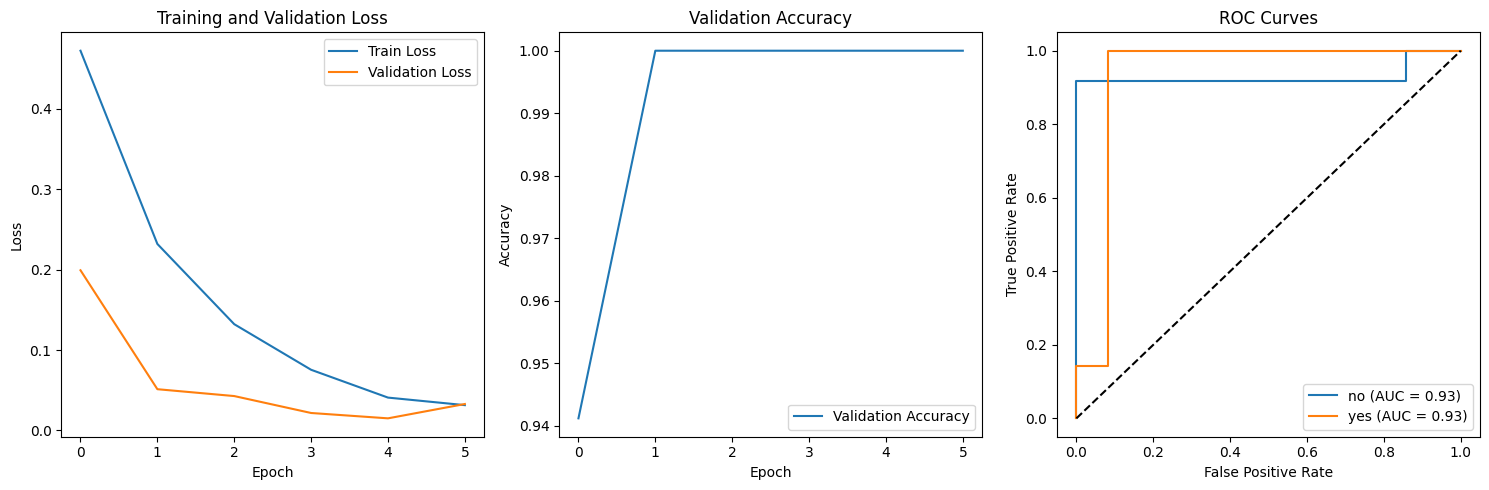

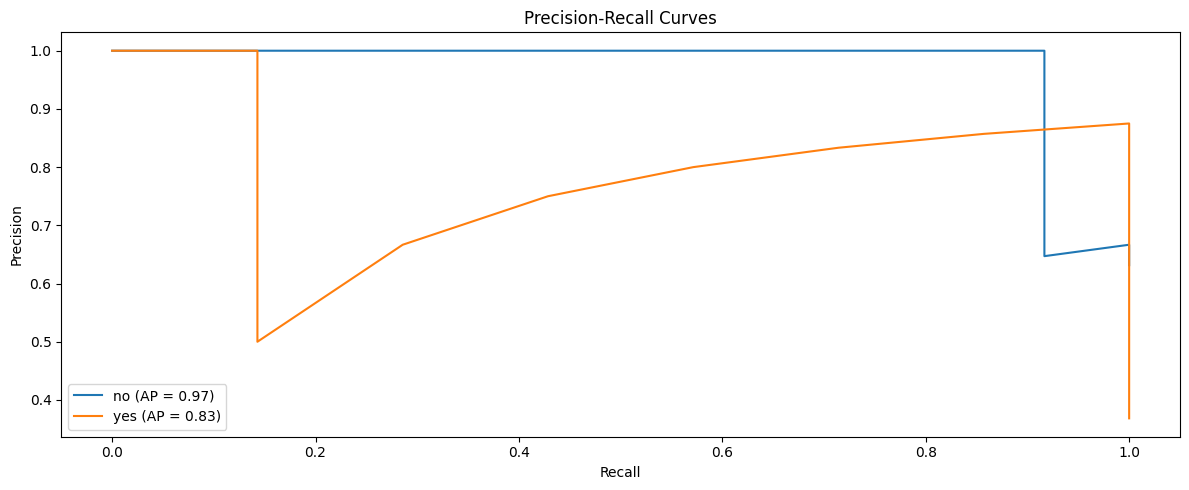

Visualization results saved to 'training_results.png' and 'precision_recall_curves.png'


In [12]:
# 3. Visualize results
print("\nStep 3: Visualizing results")
visualize_results(history)

In [14]:
!zip -r /content/enhanced_brain_tumor_dataset.zip /content/enhanced_brain_tumor_dataset

  adding: content/enhanced_brain_tumor_dataset/ (stored 0%)
  adding: content/enhanced_brain_tumor_dataset/train/ (stored 0%)
  adding: content/enhanced_brain_tumor_dataset/train/yes/ (stored 0%)
  adding: content/enhanced_brain_tumor_dataset/train/yes/Y_6_aug_0.png (deflated 0%)
  adding: content/enhanced_brain_tumor_dataset/train/yes/Y_5_aug_2.png (deflated 0%)
  adding: content/enhanced_brain_tumor_dataset/train/yes/Y_2_aug_1.png (deflated 1%)
  adding: content/enhanced_brain_tumor_dataset/train/yes/Y_28_aug_2.png (deflated 0%)
  adding: content/enhanced_brain_tumor_dataset/train/yes/Y_18_aug_1.png (deflated 0%)
  adding: content/enhanced_brain_tumor_dataset/train/yes/Y_25_aug_2.png (deflated 0%)
  adding: content/enhanced_brain_tumor_dataset/train/yes/Y_12_aug_0.png (deflated 0%)
  adding: content/enhanced_brain_tumor_dataset/train/yes/Y_1.jpg (deflated 1%)
  adding: content/enhanced_brain_tumor_dataset/train/yes/Y_18_aug_0.png (deflated 0%)
  adding: content/enhanced_brain_tumor_d

In [15]:
!zip -r /content/tensorboard_logs.zip /content/tensorboard_logs

  adding: content/tensorboard_logs/ (stored 0%)
  adding: content/tensorboard_logs/events.out.tfevents.1764009555.7c4e1424eb1c.1080.2 (deflated 91%)
  adding: content/tensorboard_logs/events.out.tfevents.1764009757.7c4e1424eb1c.1080.3 (deflated 91%)
  adding: content/tensorboard_logs/events.out.tfevents.1764009256.7c4e1424eb1c.1080.0 (deflated 93%)
  adding: content/tensorboard_logs/events.out.tfevents.1764009442.7c4e1424eb1c.1080.1 (deflated 93%)



Step 4: Demonstrating advanced fuzzy enhancements


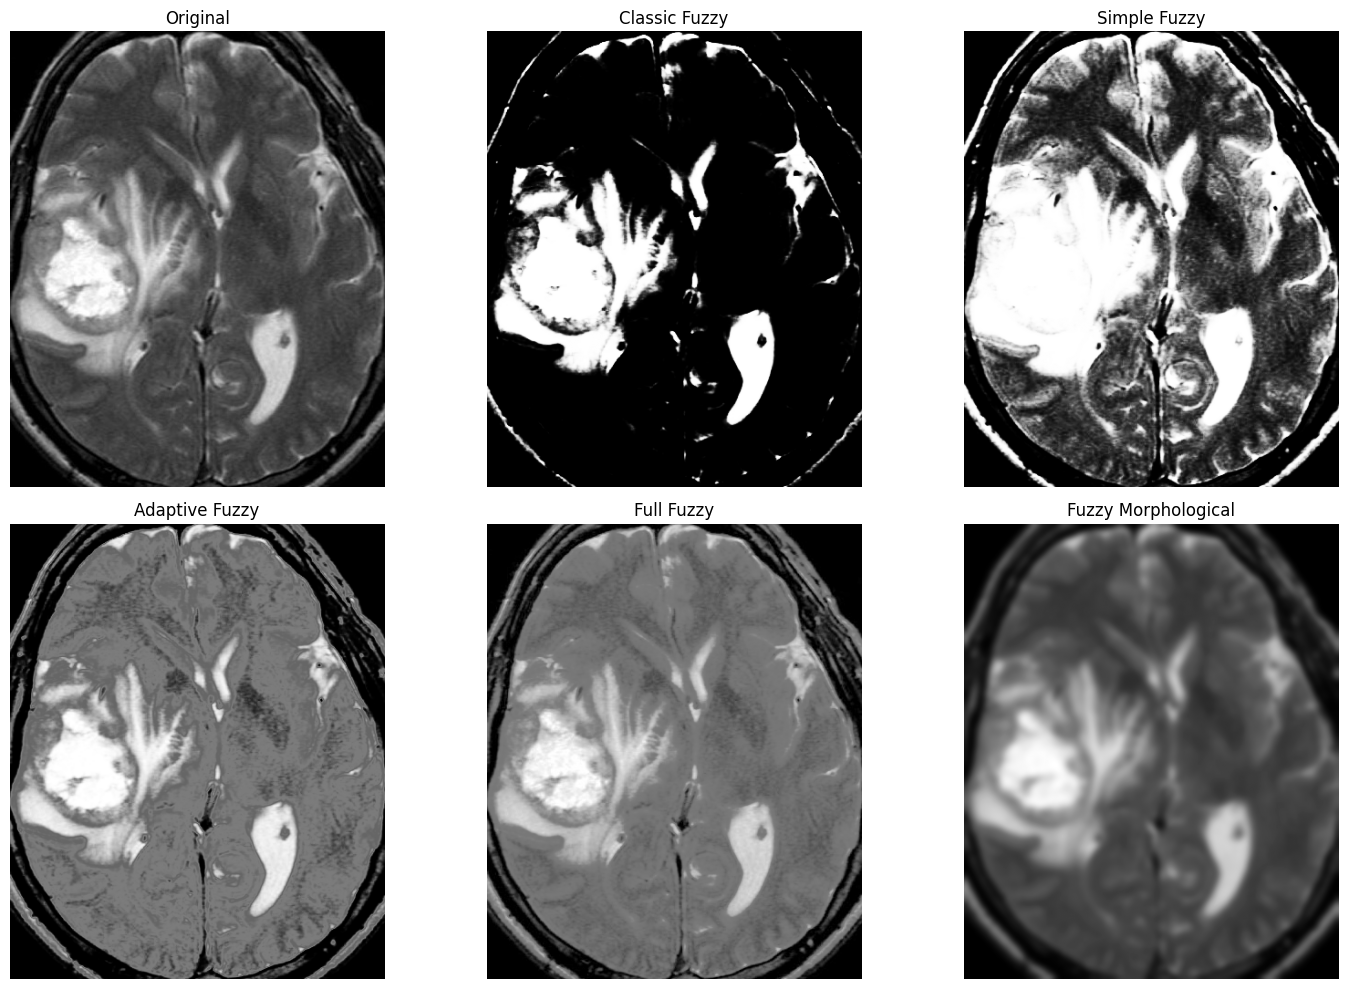


Pipeline completed successfully!
Review XAI visualizations in the saved image files
TensorBoard logs are available in the tensorboard_logs directory


In [13]:
print("\nStep 4: Demonstrating advanced fuzzy enhancements")
# Load a sample image for demonstration
test_files = os.listdir(os.path.join(enhanced_data_dir, 'test', 'yes'))
if test_files:
    sample_img_path = os.path.join(enhanced_data_dir, 'test', 'yes', test_files[0])
    sample_img = cv2.imread(sample_img_path)
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    # Create enhancer and apply different fuzzy methods
    enhancer = MedicalImageEnhancer(visualization=True)

    # Apply different fuzzy methods
    fuzzy_classic = enhancer.fuzzy_enhancement(sample_img_rgb, method='classic')
    fuzzy_simple = enhancer.fuzzy_enhancement(sample_img_rgb, method='simple')
    fuzzy_adaptive = enhancer.fuzzy_enhancement(sample_img_rgb, method='adaptive')
    fuzzy_full = enhancer.fuzzy_enhancement(sample_img_rgb, method='full')
    fuzzy_morph = enhancer.morphological_enhancement(sample_img_rgb, method='fuzzy')

    # Visualize
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(sample_img_rgb)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(fuzzy_classic, cmap='gray')
    plt.title('Classic Fuzzy')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(fuzzy_simple, cmap='gray')
    plt.title('Simple Fuzzy')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(fuzzy_adaptive, cmap='gray')
    plt.title('Adaptive Fuzzy')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(fuzzy_full, cmap='gray')
    plt.title('Full Fuzzy')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(fuzzy_morph, cmap='gray')
    plt.title('Fuzzy Morphological')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('fuzzy_enhancements.png')
    plt.show()

print("\nPipeline completed successfully!")
print("Review XAI visualizations in the saved image files")
print("TensorBoard logs are available in the tensorboard_logs directory")


Step 3: Visualizing results


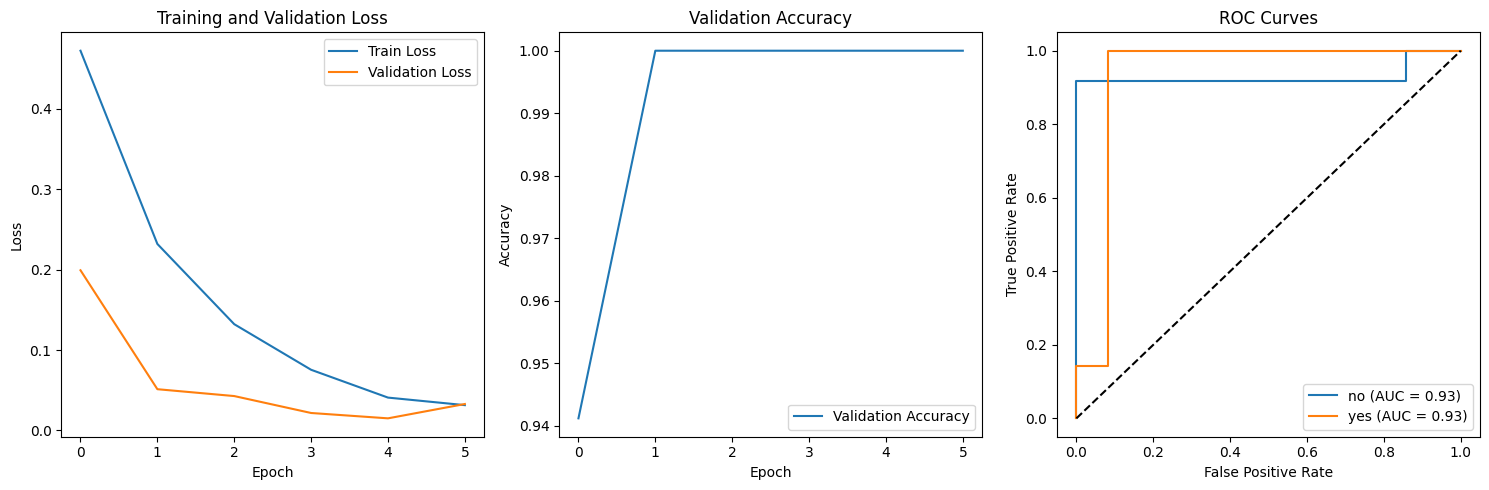

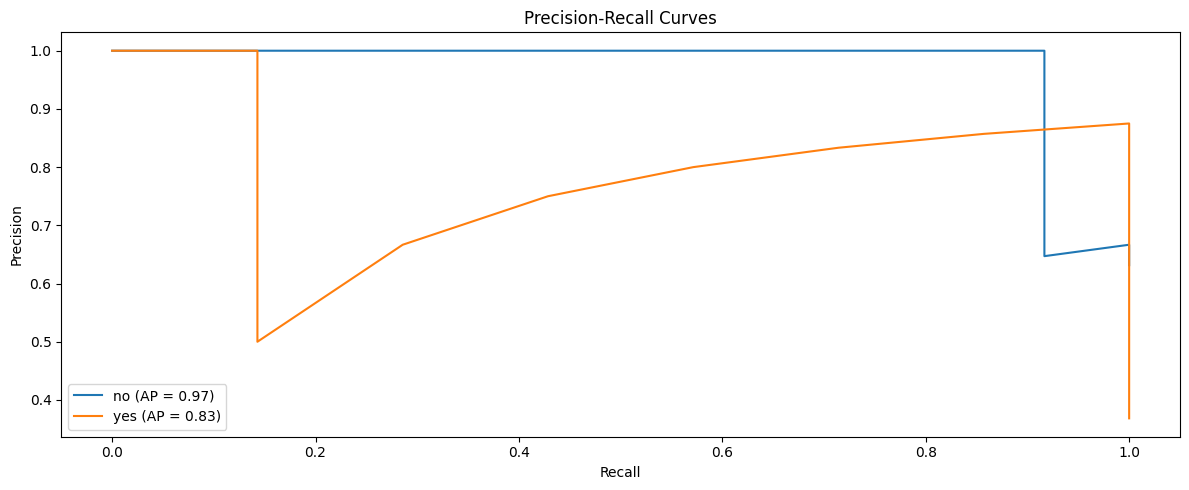

Visualization results saved to 'training_results.png' and 'precision_recall_curves.png'


In [16]:
# 3. Visualize results
print("\nStep 3: Visualizing results")
visualize_results(history)


Step 4: Demonstrating advanced fuzzy enhancements


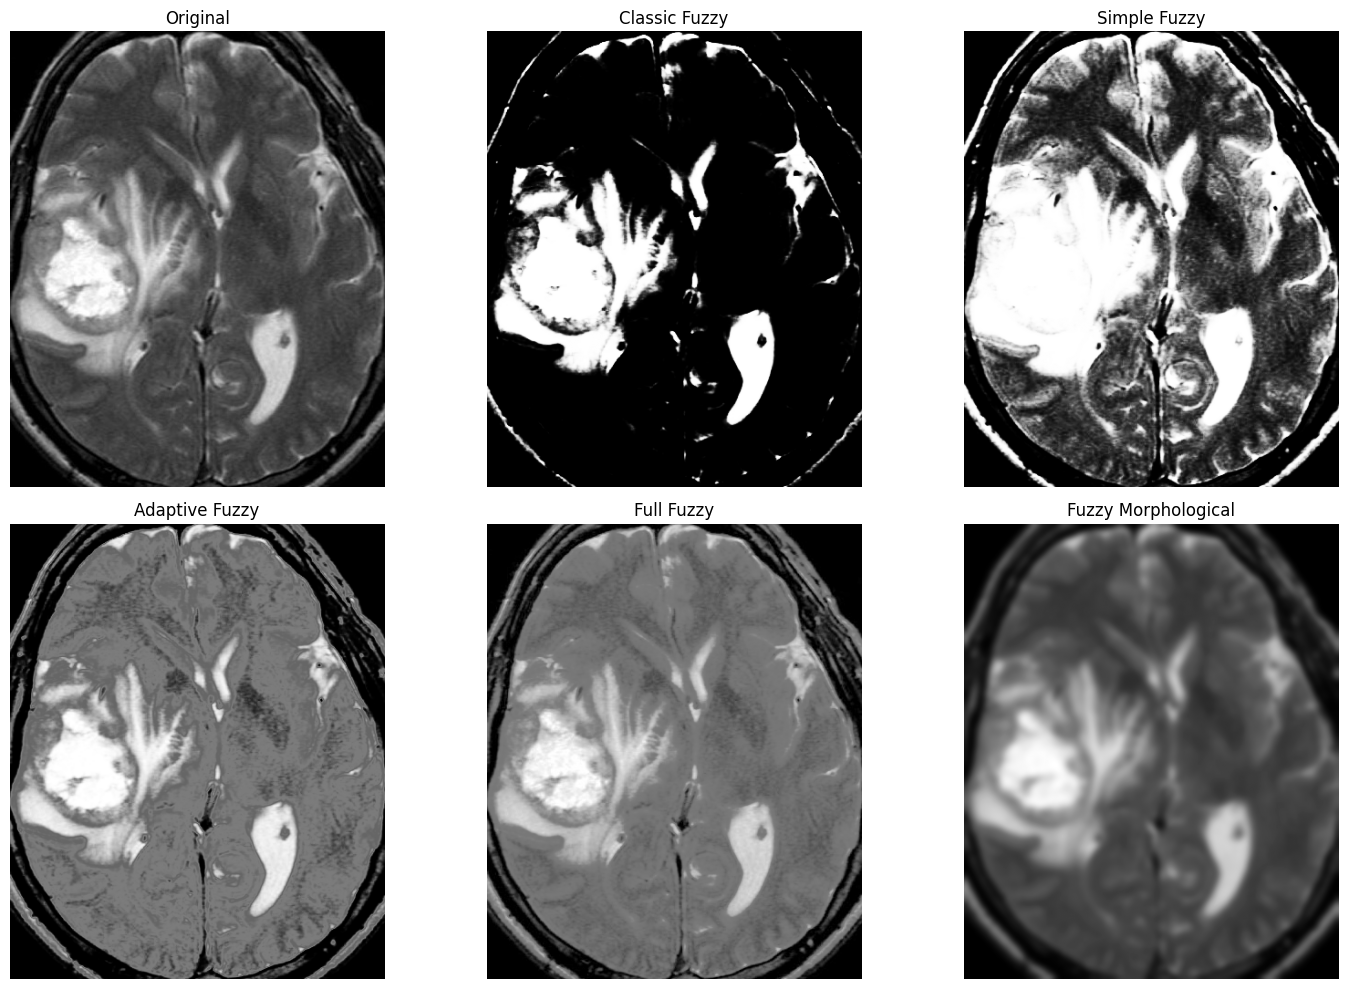


Pipeline completed successfully!
Review XAI visualizations in the saved image files
TensorBoard logs are available in the tensorboard_logs directory


In [17]:
print("\nStep 4: Demonstrating advanced fuzzy enhancements")
# Load a sample image for demonstration
test_files = os.listdir(os.path.join(enhanced_data_dir, 'test', 'yes'))
if test_files:
    sample_img_path = os.path.join(enhanced_data_dir, 'test', 'yes', test_files[0])
    sample_img = cv2.imread(sample_img_path)
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    # Create enhancer and apply different fuzzy methods
    enhancer = MedicalImageEnhancer(visualization=True)

    # Apply different fuzzy methods
    fuzzy_classic = enhancer.fuzzy_enhancement(sample_img_rgb, method='classic')
    fuzzy_simple = enhancer.fuzzy_enhancement(sample_img_rgb, method='simple')
    fuzzy_adaptive = enhancer.fuzzy_enhancement(sample_img_rgb, method='adaptive')
    fuzzy_full = enhancer.fuzzy_enhancement(sample_img_rgb, method='full')
    fuzzy_morph = enhancer.morphological_enhancement(sample_img_rgb, method='fuzzy')

    # Visualize
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(sample_img_rgb)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(fuzzy_classic, cmap='gray')
    plt.title('Classic Fuzzy')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(fuzzy_simple, cmap='gray')
    plt.title('Simple Fuzzy')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(fuzzy_adaptive, cmap='gray')
    plt.title('Adaptive Fuzzy')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(fuzzy_full, cmap='gray')
    plt.title('Full Fuzzy')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(fuzzy_morph, cmap='gray')
    plt.title('Fuzzy Morphological')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('fuzzy_enhancements.png')
    plt.show()

print("\nPipeline completed successfully!")
print("Review XAI visualizations in the saved image files")
print("TensorBoard logs are available in the tensorboard_logs directory")

In [18]:
!zip -r /content/enhanced_brain_tumor_dataset.zip /content/enhanced_brain_tumor_dataset

updating: content/enhanced_brain_tumor_dataset/ (stored 0%)
updating: content/enhanced_brain_tumor_dataset/train/ (stored 0%)
updating: content/enhanced_brain_tumor_dataset/train/yes/ (stored 0%)
updating: content/enhanced_brain_tumor_dataset/train/yes/Y_6_aug_0.png (deflated 0%)
updating: content/enhanced_brain_tumor_dataset/train/yes/Y_5_aug_2.png (deflated 0%)
updating: content/enhanced_brain_tumor_dataset/train/yes/Y_2_aug_1.png (deflated 1%)
updating: content/enhanced_brain_tumor_dataset/train/yes/Y_28_aug_2.png (deflated 0%)
updating: content/enhanced_brain_tumor_dataset/train/yes/Y_18_aug_1.png (deflated 0%)
updating: content/enhanced_brain_tumor_dataset/train/yes/Y_25_aug_2.png (deflated 0%)
updating: content/enhanced_brain_tumor_dataset/train/yes/Y_12_aug_0.png (deflated 0%)
updating: content/enhanced_brain_tumor_dataset/train/yes/Y_1.jpg (deflated 1%)
updating: content/enhanced_brain_tumor_dataset/train/yes/Y_18_aug_0.png (deflated 0%)
updating: content/enhanced_brain_tumor_d

In [19]:
!zip -r /content/tensorboard_logs.zip /content/tensorboard_logs

updating: content/tensorboard_logs/ (stored 0%)
updating: content/tensorboard_logs/events.out.tfevents.1764009555.7c4e1424eb1c.1080.2 (deflated 91%)
updating: content/tensorboard_logs/events.out.tfevents.1764009757.7c4e1424eb1c.1080.3 (deflated 91%)
updating: content/tensorboard_logs/events.out.tfevents.1764009256.7c4e1424eb1c.1080.0 (deflated 93%)
updating: content/tensorboard_logs/events.out.tfevents.1764009442.7c4e1424eb1c.1080.1 (deflated 93%)
